# Simplified Detection Efficiency Model

Update to: V. C. Chmielewski and E. C. Bruning (2016), Lightning Mapping Array flash detection performance with variable receiver thresholds, J. Geophys. Res. Atmos., 121, 8600-8614, doi:10.1002/2016JD025159

Description: Instead of propogating random sources to the network, this calculates the minimum power that a given number of stations can sense at each grid point. These minimum powers are then related to the distribution of source powers as described in the paper above to estimate the detection efficincy.

Contact:
vanna.chmielewski@noaa.gov

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import parsed_functions as pf
from mpl_toolkits.basemap import Basemap
from coordinateSystems import TangentPlaneCartesianSystem, GeographicSystem, MapProjection

In [10]:
c0 = 3.0e8 # m/s
dt_rms = 23.e-9 # seconds

sq = np.load('source_quantiles',fix_imports=True, encoding='latin1', allow_pickle=True) # in Watts 
fde = 100-np.load('fde.csv',fix_imports=True, encoding='latin1', allow_pickle=True) # Corresponding flash DE

### Station coordinates and thresholds from a set of log files 
#### Specify: 
* start time 
* end time 
* the directory holding the log files 
* any stations you wish to exclude from the analysis

In [4]:
# import read_logs
# import os
# import datetime

# # start_time = datetime.datetime(2014,5,26,2) #25 set
# # end_time   = datetime.datetime(2014,5,26,3,50)
# useddir = '/Users/Vanna/Documents/logs/'
# exclude = np.array(['W','A',])

# days = np.array([start_time+datetime.timedelta(days=i) for i in range((end_time-start_time).days+1)])
# days_string = np.array([i.strftime("%y%m%d") for i in days])

# logs = pd.DataFrame()
# dir = os.listdir(useddir)
# for file in dir:
#     if np.any(file[2:] == days_string) & np.all(exclude!=file[1]): 
#         print file
#         logs = logs.combine_first(read_logs.parsing(useddir+file,T_set='True'))

# aves = logs[start_time:end_time].mean()
# aves = np.array(aves).reshape(4,len(aves)/4).T

### Station coordinates from csv file

Input network title and csv file here

In [11]:
Network = 'grid_LMA' # name of network in the csv file

# network csv file with one or multiple networks
stations = pd.read_csv('network.csv') 
aves = np.array(stations.set_index('network').loc[Network])[:,:-1].astype('float')

### Converting and checking station locations

In [12]:
center = (np.mean(aves[:,1]), np.mean(aves[:,2]), np.mean(aves[:,0]))
geo  = GeographicSystem()
tanp = TangentPlaneCartesianSystem(center[0], center[1], center[2])
mapp = MapProjection
projl = MapProjection(projection='laea', lat_0=center[0], lon_0=center[1])

alt, lat, lon  = aves[:,:3].T

In [13]:
plt.scatter(lon, lat, c=aves[:,3])
plt.colorbar(label='Station Threshold (dBm)')
plt.show()

### Inclusive function for detection calculations

* Make sure the input array of station information matches the given dimensions
* Will check for solution in the line of sight for each station within 300 km of the network at the chosen altitude (default = 7 km) and grid spacing (default = 5 km)
* Minimum number of stations required to participate in solutions can be set (default = 6)

In [14]:
latp, lonp, sde, fde_a, minp = pf.quick_method(
                 # input array must be in N x (lat, lon, alt, threshold) 
                 np.array([aves[:,1],aves[:,2],aves[:,0],aves[:,3]]).transpose(), 
                 sq, fde, 
                 xint=5000, # Grid spacing
                 altitude=7000, # Altitude of grid MSL
                 station_requirement=6, # Minimum number of stations required to trigger
                )

### Detection efficiency plots

In [15]:
domain = 197.5*1000
maps = Basemap(projection='laea', resolution='i',
               lat_0=center[0], lon_0=center[1], width=domain*2, height=domain*2)
x, y = maps(lonp, latp)

# Source detection efficiency
s = plt.pcolormesh(x,y,sde,cmap = 'magma')
plt.colorbar(label='Source Detection Efficiency')
s.set_clim(vmin=0,vmax=100)

# Draw flash detection efficiency contours
CS = plt.contour(x,y,fde_a, colors='k',levels=(20,40,60,70,80,85,90,95,99))
plt.clabel(CS, inline=1, fontsize=10,fmt='%3.0f')

# Overlay station locations
xs, ys = maps(lon,lat) 
plt.scatter(xs,ys, color='k',s=5)

maps.drawstates()
maps.drawcoastlines()
# maps.drawcounties()
plt.show()

/home/camila/miniconda3/envs/lmasimulation/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/camila/miniconda3/envs/lmasimulation/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


### Minimum Detectable Power plotting

In [16]:
minp=np.ma.masked_where(minp==999,minp) # Undetected sources given value of 999

In [17]:
domain = 197.5*1000
maps = Basemap(projection='laea', resolution='i',
               lat_0=center[0], lon_0=center[1], width=domain*2, height=domain*2)
x, y = maps(lonp, latp)

# Source detection efficiency
s = plt.pcolormesh(x,y,minp,cmap = 'viridis_r')
plt.colorbar(label='Minimum Detectable Power (dBW)')

# Overlay station locations
xs, ys = maps(lon,lat) 
plt.scatter(xs,ys, color='k',s=5)

maps.drawstates()
maps.drawcoastlines()
# maps.drawcounties()
plt.show()

/home/camila/miniconda3/envs/lmasimulation/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/camila/miniconda3/envs/lmasimulation/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


____
______
## Additional functions

### Want to use cartopy to plot instead?

Start here

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ModuleNotFoundError: No module named 'cartopy'

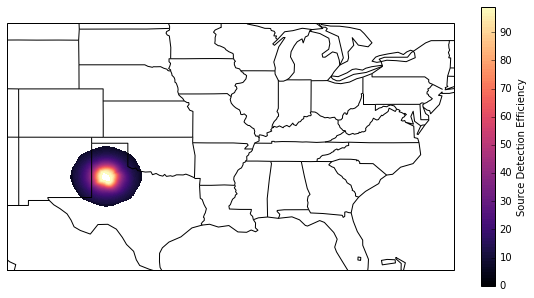

In [14]:
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lonp, latp, np.ma.masked_where(sde<1, sde), 
             levels=np.arange(0,100,1), cmap='magma', transform=ccrs.PlateCarree())
plt.colorbar(label='Source Detection Efficiency')

ax.set_extent((-110, -73, 26, 45))
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')
lakes = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='110m',
    facecolor='none')
ax.add_feature(lakes, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
ax.coastlines()

plt.show()

### Want to try multiple network calculations at once?

Start here

In [15]:
stations = pd.read_csv('network_full.csv') # network csv file with one or multiple networks

names = [['OKLMA_DC3','OKLMA_DC3sw','WTLMA'],
         'COLMA_DC3',
         'NALMA_DC3',
         ]

lats = [0]*len(names)
lons = [0]*len(names)
sdes = [0]*len(names)
fdes = [0]*len(names)
powr = [0]*len(names)

for i in range(len(names)):
    aves = np.array(stations.set_index('network').loc[names[i]])[:,:-1].astype('float')
#     aves[:,-1] = -78
    lats[i],lons[i],sdes[i],fdes[i],powr[i] = pf.quick_method(
        np.array([aves[:,1],aves[:,2],aves[:,0],aves[:,3]]).transpose(),
        sq, 
        fde, 
        xint=5000, 
        altitude=7000,
        station_requirement=6,
    )

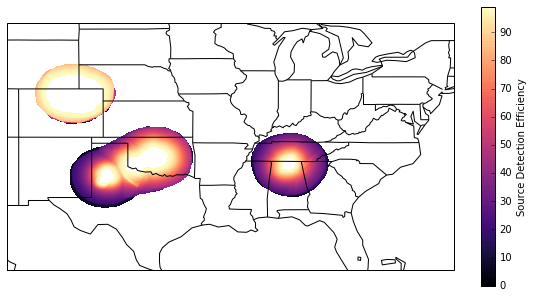

In [16]:
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())

for i in range(len(lats)):
#     plt.contourf(lons[i], lats[i], np.ma.masked_where(fdes[i]<50, fdes[i]), 
    plt.contourf(lons[i], lats[i], np.ma.masked_where(sdes[i]<1, sdes[i]), 
                 levels=np.arange(0,100,1), cmap='magma', transform=ccrs.PlateCarree())
plt.colorbar(label='Source Detection Efficiency')

ax.set_extent((-110, -73, 26, 45))
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')
lakes = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='110m',
    facecolor='none')
ax.add_feature(lakes, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
ax.coastlines()

plt.show()